In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import losses
from keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import scipy
import logging
import matplotlib.pyplot as plt
import os
import imageio
import numpy as np
import pickle

In [ ]:
"""Convolutional-recurrent GRU layer."""

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.python.keras.layers.convolutional_recurrent import ConvRNN2D

class ConvGRU2DCell(DropoutRNNCellMixin, Layer):
  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    super(ConvGRU2DCell, self).__init__(**kwargs)
    self.filters = filters
    self.kernel_size = conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
    self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
    self.padding = conv_utils.normalize_padding(padding)
    self.data_format = conv_utils.normalize_data_format(data_format)
    self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, 2,
                                                    'dilation_rate')
    self.activation = activations.get(activation)
    self.recurrent_activation = activations.get(recurrent_activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)
    
    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    self.state_size = (self.filters)

  def build(self, input_shape):
    if self.data_format == 'channels_first':
      channel_axis = 1
    else:
      channel_axis = -1
    if input_shape[channel_axis] is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    input_dim = input_shape[channel_axis]
    kernel_shape = self.kernel_size + (input_dim, self.filters * 3)
    self.kernel_shape = kernel_shape
    recurrent_kernel_shape = self.kernel_size + (self.filters, self.filters * 3) 

    self.kernel = self.add_weight(shape=kernel_shape,
                                  initializer=self.kernel_initializer,
                                  name='kernel',
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
    self.recurrent_kernel = self.add_weight(
        shape=recurrent_kernel_shape,
        initializer=self.recurrent_initializer,
        name='recurrent_kernel',
        regularizer=self.recurrent_regularizer,
        constraint=self.recurrent_constraint)

    if self.use_bias:
        bias_initializer = self.bias_initializer
        self.bias = self.add_weight(
          shape=(self.filters * 3,),
          name='bias',
          initializer=bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint)
    else:
        self.bias = None
    self.built = True

  def call(self, inputs, states, training=None):
    h_tm1 = states[0]  # previous memory state

    # dropout matrices for input units
    dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=3)
    # dropout matrices for recurrent units
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        h_tm1, training, count=3)

    if 0 < self.dropout < 1.:
      inputs_z = inputs * dp_mask[0]
      inputs_r = inputs * dp_mask[1]
      inputs_h = inputs * dp_mask[2]
      
    else:
      inputs_z = inputs
      inputs_r = inputs
      inputs_h = inputs
      

    if 0 < self.recurrent_dropout < 1.:
      h_tm1_z = h_tm1 * rec_dp_mask[0]
      h_tm1_r = h_tm1 * rec_dp_mask[1]
      h_tm1_h = h_tm1 * rec_dp_mask[2]
      
    else:
      h_tm1_z = h_tm1
      h_tm1_r = h_tm1
      h_tm1_h = h_tm1

    (kernel_z, kernel_r,
     kernel_h) = array_ops.split(self.kernel, 3, axis=3)
    (recurrent_kernel_z,
     recurrent_kernel_r,
     recurrent_kernel_h) = array_ops.split(self.recurrent_kernel, 3, axis=3)

    if self.use_bias:
      bias_z, bias_r, bias_h = array_ops.split(self.bias, 3)
    else:
      bias_z, bias_r, bias_h = None, None, None

    x_z = self.input_conv(inputs_z, kernel_z, bias_z, padding=self.padding)
    x_r = self.input_conv(inputs_r, kernel_r, bias_r, padding=self.padding)
    x_h = self.input_conv(inputs_h, kernel_h, bias_h, padding=self.padding)
 
    
    h_z = self.recurrent_conv(h_tm1_z, recurrent_kernel_z)
    h_r = self.recurrent_conv(h_tm1_r, recurrent_kernel_r)
    h_h = self.recurrent_conv(h_tm1_h, recurrent_kernel_h)


    z = self.recurrent_activation(x_z + h_z)
    r = self.recurrent_activation(x_r + h_r)
    
    h = (1.0 - z) * h_tm1 + z * self.activation(x_h + h_h)
    return h, [h]


  def input_conv(self, x, w, b=None, padding='valid'):
    conv_out = backend.conv2d(x, w, strides=self.strides,
                              padding=padding,
                              data_format=self.data_format,
                              dilation_rate=self.dilation_rate)
    if b is not None:
      conv_out = backend.bias_add(conv_out, b,
                                  data_format=self.data_format)
    return conv_out

  def recurrent_conv(self, x, w):
    conv_out = backend.conv2d(x, w, strides=(1, 1),
                              padding='same',
                              data_format=self.data_format)
    return conv_out

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvGRU2DCell, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


class ConvGRU2D(ConvRNN2D):
  """
  References:
    - [Shi et al., 2015](http://arxiv.org/abs/1506.04214v1)
    (the current implementation does not include the feedback loop on the
    cells output).
  Example:
  ```python
  steps = 10
  height = 32
  width = 32
  input_channels = 3
  output_channels = 6
  inputs = tf.keras.Input(shape=(steps, height, width, input_channels))
  layer = ConvGRU2D.ConvGRU2D(filters=output_channels, kernel_size=3)
  outputs = layer(inputs)
  ```
  """

  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    cell = ConvGRU2DCell(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides,
                          padding=padding,
                          data_format=data_format,
                          dilation_rate=dilation_rate,
                          activation=activation,
                          recurrent_activation=recurrent_activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          dtype=kwargs.get('dtype'))
    super(ConvGRU2D, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     return_state=return_state,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     **kwargs)
    self.activity_regularizer = regularizers.get(activity_regularizer)

  def call(self, inputs, mask=None, training=None, initial_state=None):
    return super(ConvGRU2D, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state)

  @property
  def filters(self):
    return self.cell.filters

  @property
  def kernel_size(self):
    return self.cell.kernel_size

  @property
  def strides(self):
    return self.cell.strides

  @property
  def padding(self):
    return self.cell.padding

  @property
  def data_format(self):
    return self.cell.data_format

  @property
  def dilation_rate(self):
    return self.cell.dilation_rate

  @property
  def activation(self):
    return self.cell.activation

  @property
  def recurrent_activation(self):
    return self.cell.recurrent_activation

  @property
  def use_bias(self):
    return self.cell.use_bias

  @property
  def kernel_initializer(self):
    return self.cell.kernel_initializer

  @property
  def recurrent_initializer(self):
    return self.cell.recurrent_initializer

  @property
  def bias_initializer(self):
    return self.cell.bias_initializer

  @property
  def kernel_regularizer(self):
    return self.cell.kernel_regularizer

  @property
  def recurrent_regularizer(self):
    return self.cell.recurrent_regularizer

  @property
  def bias_regularizer(self):
    return self.cell.bias_regularizer

  @property
  def kernel_constraint(self):
    return self.cell.kernel_constraint

  @property
  def recurrent_constraint(self):
    return self.cell.recurrent_constraint

  @property
  def bias_constraint(self):
    return self.cell.bias_constraint

  @property
  def dropout(self):
    return self.cell.dropout

  @property
  def recurrent_dropout(self):
    return self.cell.recurrent_dropout

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'activity_regularizer': regularizers.serialize(
                  self.activity_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvGRU2D, self).get_config()
    del base_config['cell']
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
dataset = np.load('/content/drive/My Drive/Dataset/data.npy')
dataset = np.expand_dims(dataset, axis=-1)
dataset.shape

(12638, 8, 28, 28, 1)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
test_data = np.load('/content/drive/My Drive/Dataset/data_test_full.npy')
test_data = np.expand_dims(test_data, axis=-1)
test_data.shape

(10000, 8, 28, 28, 1)

In [ ]:
def generate_noise():
  row = 28
  col = 28
  ch = 1
  mean = 0
  var = 0.1
  sigma = var**0.5
  l = np.arange(4,8)
  random_index = []
  random_index.append(np.random.choice(l))
  l = np.setdiff1d(l,random_index)
  random_index.append(np.random.choice(l))
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  return random_index, gauss

In [ ]:
# Split into train and validation sets using indexing to optimize memory.
test_index = np.arange(test_data.shape[0])
np.random.shuffle(test_index)
test_dataset = test_data[test_index]

# Normalize the data to the 0-1 range.
test_dataset = test_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_test, y_test = create_shifted_frames(test_dataset)

# Inspect the dataset.
print("Testing Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Testing Dataset Shapes: (10000, 7, 28, 28, 1), (10000, 7, 28, 28, 1)


In [ ]:
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.7 * dataset.shape[0])]
val_index = indexes[int(0.7 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (8846, 7, 28, 28, 1), (8846, 7, 28, 28, 1)
Validation Dataset Shapes: (3792, 7, 28, 28, 1), (3792, 7, 28, 28, 1)


In [ ]:
#Noising the dataset
test_dataset_noise = test_dataset.copy()
noise_index = []
for i in range(len(test_dataset_noise)):
  random_index, gauss = generate_noise()
  test_dataset_noise[i][random_index] = gauss + test_dataset_noise[i][random_index]
  noise_index.append(random_index)

test_dataset_noise = test_dataset_noise / 2
# Apply the processing function to the datasets.
x_noise, y_noise = create_shifted_frames(test_dataset_noise)

# Inspect the dataset.
print("Noise Dataset Shapes: " + str(x_noise.shape) + ", " + str(y_noise.shape))

Noise Dataset Shapes: (10000, 7, 28, 28, 1), (10000, 7, 28, 28, 1)


In [ ]:
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_val", x_val)
np.save("y_val", y_val)
np.save("train_dataset", train_dataset)
np.save("val_dataset", val_dataset)

KeyboardInterrupt: ignored

In [ ]:
np.save("x_train_GRU", x_train)
np.save("y_train_GRU", y_train)
np.save("x_val_GRU", x_val)
np.save("y_val_GRU", y_val)
np.save("train_dataset_GRU", train_dataset)
np.save("val_dataset_GRU", val_dataset)

In [ ]:
x_train = np.load('/content/drive/My Drive/Dataset/x_train.npy')
y_train = np.load('/content/drive/My Drive/Dataset/y_train.npy')
x_val = np.load('/content/drive/My Drive/Dataset/x_val.npy')
y_val = np.load('/content/drive/My Drive/Dataset/y_val.npy')
train_dataset = np.load('/content/drive/My Drive/Dataset/train_dataset.npy')
val_dataset = np.load('/content/drive/My Drive/Dataset/val_dataset.npy')

KeyboardInterrupt: ignored

In [ ]:
with open('/content/drive/My Drive/Dataset/model.pkl', 'rb') as f:
    model = pickle.load(f)

Displaying frames for example 588.


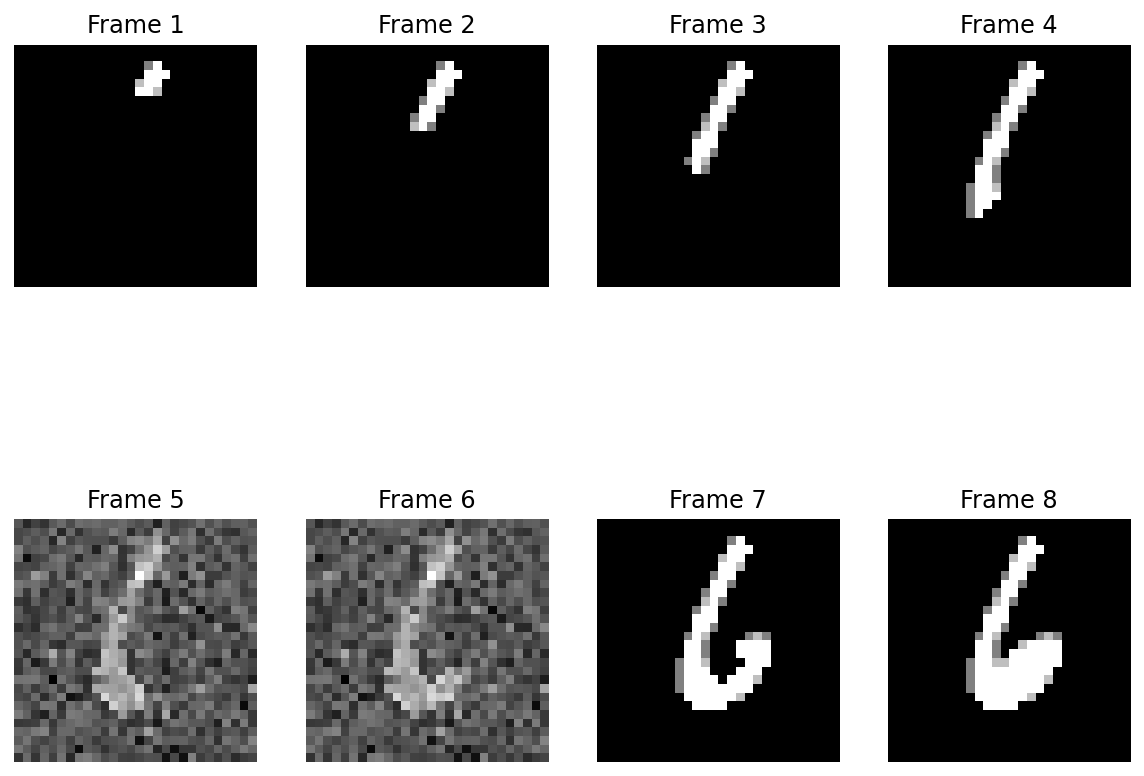

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 4, figsize=(10, 8))
random_index, gauss = generate_noise()
# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
d = train_dataset[data_choice]
d[random_index] = gauss+d[random_index]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(d[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
# Construct the input layer with no definite frame size.

import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.layers import LayerNormalization


# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = (TimeDistributed(Conv2D(128, (11, 11), strides=2, activation="relu", padding="same")))(inp)
x = (LayerNormalization())(x)
x = (TimeDistributed(Conv2D(64, (5, 5), strides=2, activation="relu", padding="same")))(x)
x = LayerNormalization()(x)
# # # # #
x = (ConvGRU2D(64, (3, 3), padding="same", activation="relu", return_sequences=True))(x)
x = LayerNormalization()(x)
x = ConvGRU2D(32, (3, 3), padding="same", activation="relu", return_sequences=True)(x)
x = LayerNormalization()(x)
x = ConvGRU2D(64, (3, 3), padding="same", activation="relu", return_sequences=True)(x)
x = LayerNormalization()(x)
# # # # #
x = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same"))(x)
x = LayerNormalization()(x)
x = TimeDistributed(Conv2DTranspose(128, (11, 11), strides=2, activation="relu", padding="same"))(x)
x = LayerNormalization()(x)
x = TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same"))(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

  <tf.Variable 'conv_gr_u2d/recurrent_kernel:0' shape=(3, 3, 64, 192) dtype=float32>
  <tf.Variable 'conv_gr_u2d/bias:0' shape=(192,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
  <tf.Variable 'conv_gr_u2d_1/recurrent_kernel:0' shape=(3, 3, 32, 96) dtype=float32>
  <tf.Variable 'conv_gr_u2d_1/bias:0' shape=(96,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
  <tf.Variable 'conv_gr_u2d_2/recurrent_kernel:0' shape=(3, 3, 64, 192) dtype=float32>
  <tf.Variable 'conv_gr_u2d_2/bias:0' shape=(192,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 28, 2 

In [ ]:
# Construct the input layer with no definite frame size.

import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.layers import LayerNormalization


# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = (TimeDistributed(Conv2D(128, (11, 11), strides=2, activation="relu", padding="same")))(inp)
x = (LayerNormalization())(x)
x = (TimeDistributed(Conv2D(64, (5, 5), strides=2, activation="relu", padding="same")))(x)
x = LayerNormalization()(x)
# # # # #
x = (ConvLSTM2D(64, (3, 3), padding="same", activation="relu", return_sequences=True))(x)
x = LayerNormalization()(x)
x = ConvLSTM2D(32, (3, 3), padding="same", activation="relu", return_sequences=True)(x)
x = LayerNormalization()(x)
x = ConvLSTM2D(64, (3, 3), padding="same", activation="relu", return_sequences=True)(x)
x = LayerNormalization()(x)
# # # # #
x = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same"))(x)
x = LayerNormalization()(x)
x = TimeDistributed(Conv2DTranspose(128, (11, 11), strides=2, activation="relu", padding="same"))(x)
x = LayerNormalization()(x)
x = TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same"))(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

NameError: ignored

In [ ]:
# Construct the input layer with no definite frame size.

import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.layers import LayerNormalization


# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = (TimeDistributed(Conv2D(128, (11, 11), strides=2, activation="relu", padding="same")))(inp)
x = (LayerNormalization())(x)
x = (TimeDistributed(Conv2D(64, (5, 5), strides=2, activation="relu", padding="same")))(x)
x = LayerNormalization()(x)
# # # # #
#Following etal Hasan's architecture which doesnt include any temporal remembrance.
# # # # #
x = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same"))(x)
x = LayerNormalization()(x)
x = TimeDistributed(Conv2DTranspose(128, (11, 11), strides=2, activation="relu", padding="same"))(x)
x = LayerNormalization()(x)
x = TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same"))(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 28, 28, 1)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, None, 14, 14, 128  15616    
 ibuted)                     )                                   
                                                                 
 layer_normalization (LayerN  (None, None, 14, 14, 128  256      
 ormalization)               )                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 7, 7, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, None, 7, 7, 64)   128   

In [ ]:
from time import time
# Define some callbacks to improve training.

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 10

# Fit the model to the training data.
start = time()
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)
print("Time taken " + str(time()-start))

Epoch 1/10
885/885 [==============================] - 67s 65ms/step - loss: 0.0740 - accuracy: 0.9070 - auc: 0.9872 - precision: 0.9475 - recall: 0.7292 - val_loss: 0.0580 - val_accuracy: 0.9082 - val_auc: 0.9940 - val_precision: 0.9688 - val_recall: 0.7580 - lr: 0.0010
Epoch 2/10
885/885 [==============================] - 56s 63ms/step - loss: 0.0560 - accuracy: 0.9089 - auc: 0.9944 - precision: 0.9718 - recall: 0.7738 - val_loss: 0.0545 - val_accuracy: 0.9083 - val_auc: 0.9948 - val_precision: 0.9707 - val_recall: 0.7854 - lr: 0.0010
Epoch 3/10
885/885 [==============================] - 56s 63ms/step - loss: 0.0529 - accuracy: 0.9090 - auc: 0.9953 - precision: 0.9719 - recall: 0.7863 - val_loss: 0.0532 - val_accuracy: 0.9086 - val_auc: 0.9951 - val_precision: 0.9730 - val_recall: 0.7624 - lr: 0.0010
Epoch 4/10
885/885 [==============================] - 56s 63ms/step - loss: 0.0510 - accuracy: 0.9090 - auc: 0.9958 - precision: 0.9723 - recall: 0.7936 - val_loss: 0.0522 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test, batch_size=10)

1000/1000 [==============================] - 20s 19ms/step - loss: 0.0582 - accuracy: 0.9072 - auc: 0.9915 - precision: 0.9603 - recall: 0.8092


[0.05818907916545868,
 0.9072107076644897,
 0.9914718866348267,
 0.9602819681167603,
 0.8092082738876343]

In [ ]:
history_test_noise = model.evaluate(x_noise, y_noise, batch_size=10)

1000/1000 [==============================] - 19s 19ms/step - loss: 0.0943 - accuracy: 0.6545 - auc: 0.6332 - precision: 0.9829 - recall: 0.1513


In [ ]:
  param = ["loss", "acc", "auc", "tn", "tp", "fn", "fp"]
history_test_noise = dict(zip(param, history_test_noise))

In [ ]:
print(history_test_noise)

{'loss': 0.1510983556509018, 'acc': 0.6425591111183167, 'auc': 0.6343222260475159, 'tn': 35135268.0, 'tp': 4033190.0, 'fn': 14879361.0, 'fp': 832172.0}


In [ ]:
def get_single_test(i):
  random_index, gauss = generate_noise()
  if i==-1:
    example = test_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
    example[random_index] = example[random_index]+gauss
  else:
    example = val_dataset[i].copy()
    example[random_index] = example[random_index]+gauss
  return example, random_index

In [ ]:
import matplotlib.pyplot as plt
def evaluate(i = -1):

    test, random_index = get_single_test(i)

    ground_truth = np.ones(4)
    random_index = np.subtract(random_index, 4)
    ground_truth[random_index] = 0;

    sz = 4
    frames = test[:4, ...]
    original_frames = test[4:, ...]

    for _ in range(4):
        # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    #Get the new frames
    new_frames = frames[4:, ...]

    # get the reconstruction cost of all the sequences
    reconstruction_cost = []
    for i in range(4):
        reconstruction_cost.append(np.linalg.norm(np.subtract(original_frames[i],new_frames[i])))
    sa = (reconstruction_cost - np.min(reconstruction_cost)) / np.max(reconstruction_cost)
    sr = 1.0 - sa
    
    # plot the regularity scores

    fig, axes = plt.subplots(1, 1, figsize=(7.35, 4))

    
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    fig, axes = plt.subplots(2, 4, figsize=(8, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 5}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[4:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 5}")
        ax.axis("off")

    # Display the figure.
    plt.show()

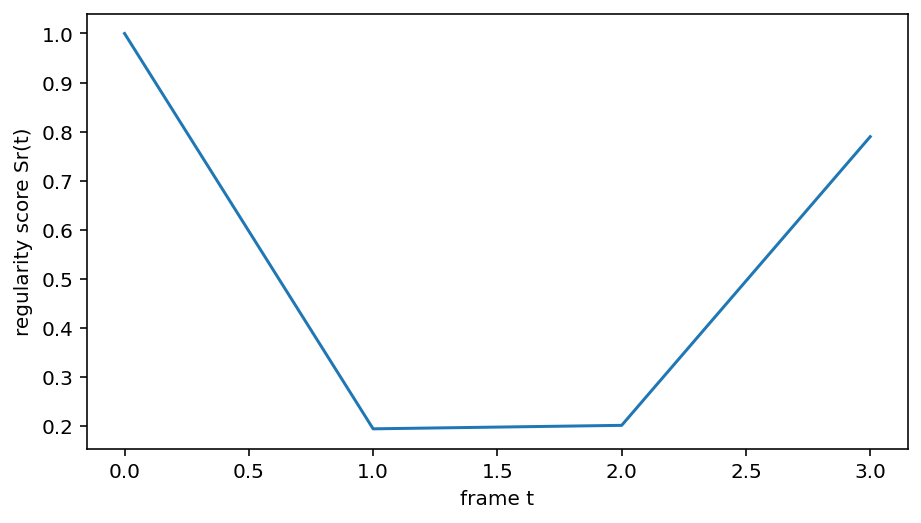

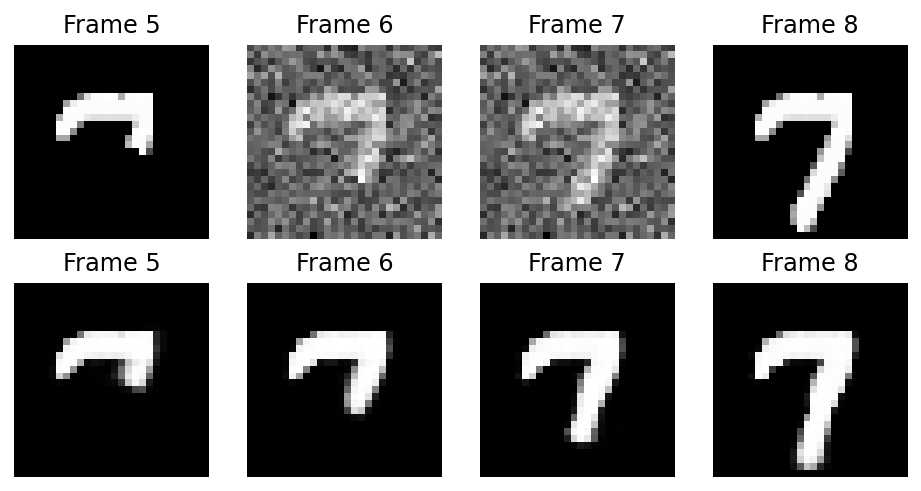

In [ ]:
evaluate(8)

In [ ]:
import matplotlib.pyplot as plt
def plot_regularity_curve(i = -1):

    test = test_dataset_noise[i]
    random_index = noise_index[i]
    ground_truth = np.ones(4)
    random_index = np.subtract(random_index, 4)
    ground_truth[random_index] = 0;

    sz = 4
    frames = test[:4, ...]
    original_frames = test[4:, ...]

    for _ in range(4):
        # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    #Get the new frames
    new_frames = frames[4:, ...]

    # get the reconstruction cost of all the sequences
    reconstruction_cost = []
    for i in range(4):
        reconstruction_cost.append(np.linalg.norm(np.subtract(original_frames[i],new_frames[i])))
    sa = (reconstruction_cost - np.min(reconstruction_cost)) / np.max(reconstruction_cost)
    sr = 1.0 - sa
    predicted_value = list(np.floor(sr+0.3))
    new_frames = frames[4:, ...]
    return ground_truth, predicted_value

In [ ]:
y_truth = []
y_pred = []

DATASET = test_dataset_noise
for i in range(len(DATASET)):
  t, p = plot_regularity_curve(i)
  for j in t:
    y_truth.append(j)
  for j in p:
    y_pred.append(j)

# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_truth, y_pred)
# auc_keras = auc(fpr_keras, tpr_keras)
# print(fpr_keras, tpr_keras)

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [ ]:
anomaly_count = 0
false_alarm = 0
anomaly_detected = 0
unsimilar = 0;
for i in range(len(y_pred)):
  if y_truth[i]!=y_pred[i]:
        unsimilar+=1
  if y_truth[i]==0:
    anomaly_count+=1
    if y_pred[i]==0:
      anomaly_detected+=1
  if y_pred[i]==0 and y_truth[i]==1:
    false_alarm+=1
print(anomaly_count, false_alarm, anomaly_detected, unsimilar)

20000 2050 14387 7663


In [ ]:
    cnt = 0
for i in range(len(y_pred)):
  if y_pred[i]!=y_truth[i]:
    cnt+=1
print(cnt)

486


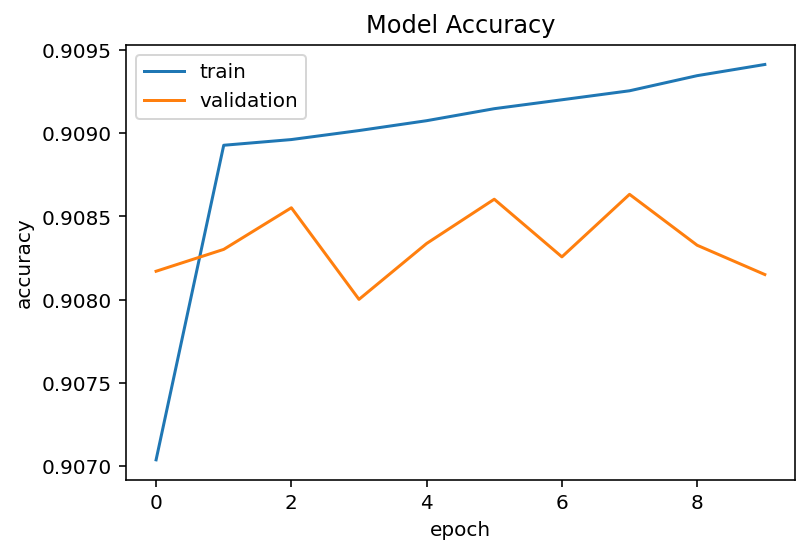

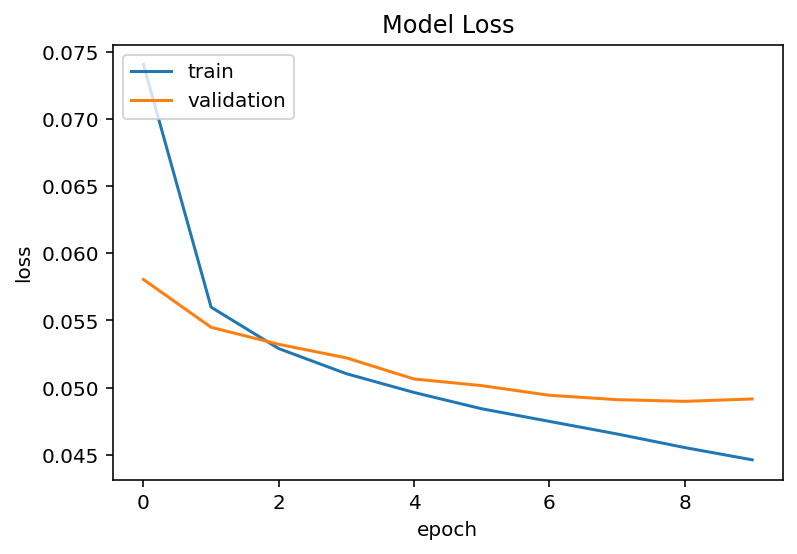

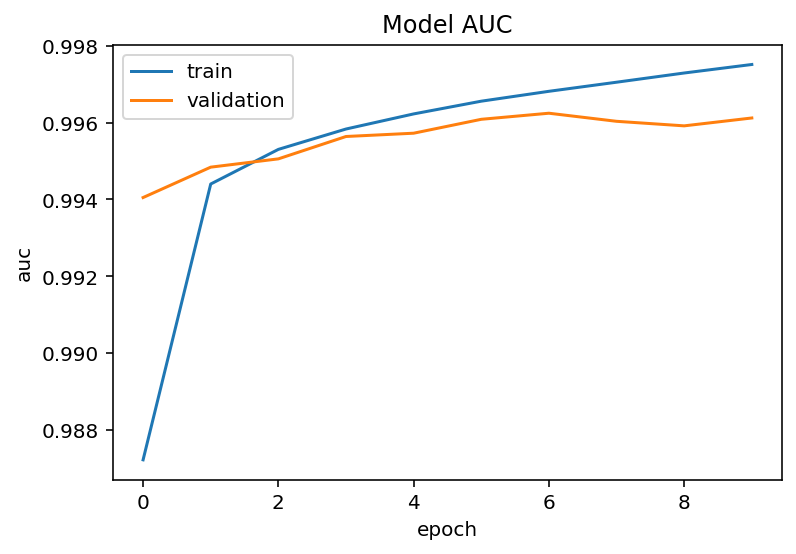

In [ ]:
# summarise history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#summarise AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
import pickle
with open('model_GRU.pkl', 'wb') as f:
    pickle.dump(model, f)

AssertionError: ignored

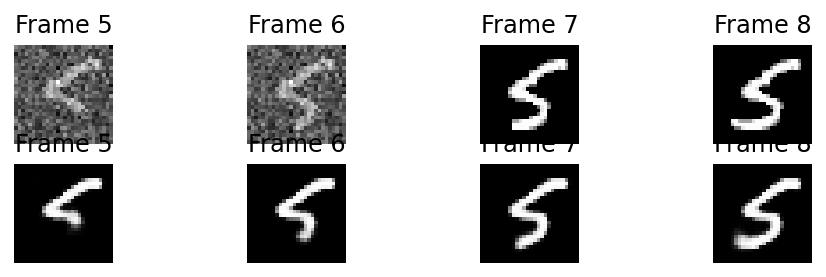

[9.238698686625062, 9.51360687874994, 4.156786442419575, 4.2918378557850705]


In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
random_index, gauss = generate_noise()
example[random_index] = example[random_index]+gauss

# Pick the first/last ten frames from the example.
frames = example[:4, ...]
original_frames = example[4:, ...]

# Predict a new set of 4 frames.
for _ in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 4, figsize=(8, 2))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 5}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[4:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 5}")
    ax.axis("off")

# Display the figure.
plt.show()

reconstruction_cost = []
for i in range(4):
    reconstruction_cost.append(np.linalg.norm(np.subtract(original_frames[i],new_frames[i])))
print(reconstruction_cost)


In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:1, ...]
    original_frames = example[1:, ...]
    new_predictions = np.zeros(shape=(7, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(7):
        # Extract the model's prediction and post-process it.
        frames = example[: 1 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


In [ ]:
!cat /proc/meminfo

MemTotal:       13298580 kB
MemFree:          164116 kB
MemAvailable:    6546004 kB
Buffers:           80224 kB
Cached:          3694656 kB
SwapCached:            0 kB
Active:          8651944 kB
Inactive:        4074284 kB
Active(anon):    6139048 kB
Inactive(anon):    14792 kB
Active(file):    2512896 kB
Inactive(file):  4059492 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               800 kB
Writeback:             0 kB
AnonPages:       8951152 kB
Mapped:          1693336 kB
Shmem:             15556 kB
KReclaimable:     101900 kB
Slab:             165260 kB
SReclaimable:     101900 kB
SUnreclaim:        63360 kB
KernelStack:        6432 kB
PageTables:        42828 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:   11687000 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       52608 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-74bcf6a7-29f0-3338-49d8-558d7c75afd2)
